In [1]:
%matplotlib inline
import numpy as  np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
})

from scipy.integrate import odeint
import math
from module import *


#Initial mass of the dark halo of PBH having mass M_PBH given by eq.(24) in "PBH-                                                                                       binary" notes.  
def λ(s):
    return λ_0*n(s)

 
def s_dec(λ_0):   # Function to calculate the scale-factor of the PBH binary decouple from Hubble flow.
    def f(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]   
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=(As[i]*λ_0)             # As ss=s/λ_0.
        if Δ<0:
            break
        
    return s







def a(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        semi=(((A/2)*λ_0))                   #As Bs=separations/λ_0.
        if Δ<0:
            x=(((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))    # The initial comoving separation of the PBH binary in units of meter.
            a=(x*semi)
            break
        
    
    return a


# The binding energy, E_b of the dark matter halos calculated within r_s and r_ta for dark matter halo's density profile of ρ(r)∝ r^{-9/4}
def E_b(M_PBH,λ_0,s): 
    return ((16*π*G*ρ_bar(M_PBH)*M_PBH*(((r_ta(M_PBH,s))**(-1/4))-((r_s(M_PBH))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(M_PBH)**2)*(((r_ta(M_PBH,s))**(1/2))-((r_s(M_PBH))**(1/2)))))

   
def a_f(λ_0,a_i,s): #Final semi-major axis of the PBH binary.
    return ((G*M_1PBH*M_2PBH*a_i)/((G*M_(M_1PBH,s)*M_(M_2PBH,s))-(2*a_i*(E_b(M_1PBH,λ_0,s)+E_b(M_2PBH,λ_0,s)))))



s_dec_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate(λ_list):
    s_dec_list[i]= s_dec(λ_0)
       

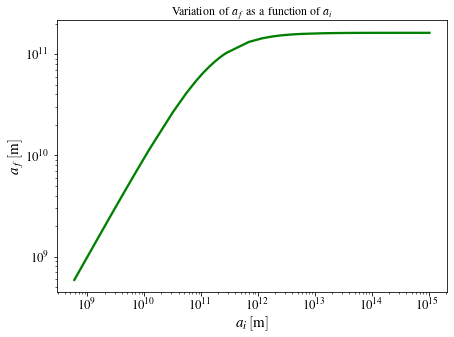

In [2]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=M_2PBH=1M☉. 

M_1PBH=1*M_solar      # in units of kg
M_2PBH=1*M_solar     # in units of kg



a_i_1_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_1_list[i] = a(λ_0)

    
a_f_1_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_1_list,s_dec_list)):
    a_f_1_list[i]=a_f(λ_0,a_i,s)
    


plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_1_list,a_f_1_list,'g')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

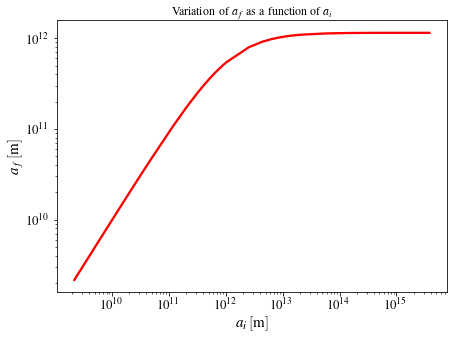

In [3]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=M_2PBH=50M☉. 

M_1PBH=50*M_solar      # in units of kg
M_2PBH=50*M_solar     # in units of kg



a_i_2_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_2_list[i] = a(λ_0)

    
a_f_2_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_2_list,s_dec_list)):
    a_f_2_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_2_list,a_f_2_list,'r')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

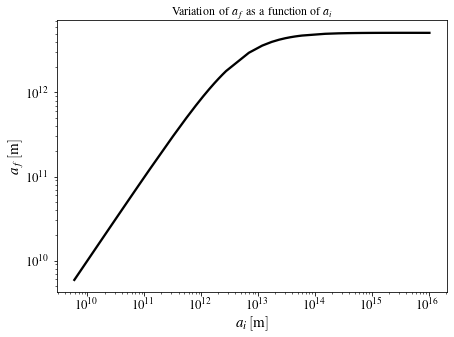

In [4]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=M_2PBH=1000M☉. 

M_1PBH=1000*M_solar      # in units of kg
M_2PBH=1000*M_solar     # in units of kg



    
a_i_3_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_3_list[i] = a(λ_0)

    
a_f_3_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_3_list,s_dec_list)):
    a_f_3_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_3_list,a_f_3_list,'k')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

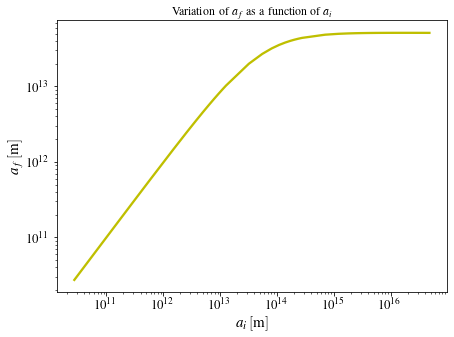

In [5]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=M_2PBH=1e5M☉. 

M_1PBH=1e5*M_solar      # in units of kg
M_2PBH=1e5*M_solar     # in units of kg



    
a_i_4_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_4_list[i] = a(λ_0)

    
a_f_4_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_4_list,s_dec_list)):
    a_f_4_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_4_list,a_f_4_list,'y')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

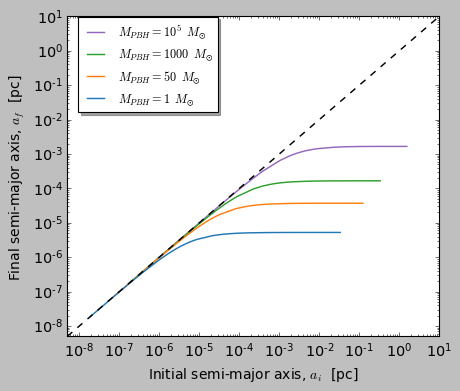

In [6]:
#Combined plot of a_f vs a_i for M_1PBH=M_2PBH≡M_PBH.


pc=3.085e16   # in units of meter
C=1/pc

A=np.geomspace(5e-9,10,1000000)
A_i_list=A.tolist()

def A_f(A_i):
    return A_i

A_f_list=np.zeros(len(A_i_list))
for i, A_i  in enumerate (A_i_list):
    A_f_list[i]=A_f(A_i)
    


plt.style.use('classic')

plt.figure(figsize=(6,5))
plt.rc('lines', linewidth=1.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_4_list*C,a_f_4_list*C,'tab:purple')
plt.loglog(a_i_3_list*C,a_f_3_list*C,'tab:green')
plt.loglog(a_i_2_list*C,a_f_2_list*C,'tab:orange')
plt.loglog(a_i_1_list*C,a_f_1_list*C,'tab:blue')
plt.loglog(A_i_list,A_f_list,'k--')
plt.xlim(5e-9,10)
plt.ylim(5e-9,10)

plt.xlabel('Initial semi-major axis, $a_{i}$  [pc]',fontsize=12.5)
plt.ylabel('Final semi-major axis, $a_{f}$  [pc]',fontsize=12.5)
plt.legend(['$M_{PBH}=10^{5}\hspace{0.5} M_{☉}$','$M_{PBH}=1000\hspace{0.5} M_{☉}$','$M_{PBH}=50\hspace{0.5} M_{☉}$',
            '$M_{PBH}=1\hspace{0.5} M_{☉}$'], prop = {'size':11}, facecolor = 'white',loc=(0.03,0.7),shadow = True,fontsize=33)

plt.savefig('a_f vs a_i with equal PBH masses.pdf')
plt.show()

In [7]:
# Plots of a_f vs a_i  of the PBH binary for the density profile of  ρ(r)∝ r^{-9/4},
# keeping mass of the one PBH fixed and varying the other PBH mass
# (Here M_1PBH is fixed and the M_2PBH is being varied).
# The binary is having no halos in the final configuration and hence their final size if given
# by the Schwarzchild radii of the PBHs in the binary.

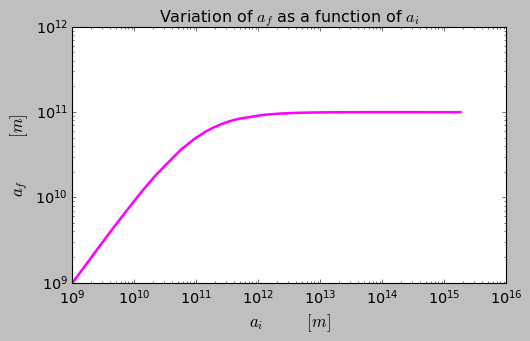

In [7]:
#Plot of a_f vs a_i for M_1PBH=10M☉ and M_2PBH=1M☉.


M_1PBH=10*M_solar      # in units of kg
M_2PBH=1*M_solar       # in units of kg



a_i_5_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_5_list[i] = a(λ_0)

    
a_f_5_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_5_list,s_dec_list)):
    a_f_5_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,4))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_5_list,a_f_5_list,'#FF00FF')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.ylim(1e9,1e12)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

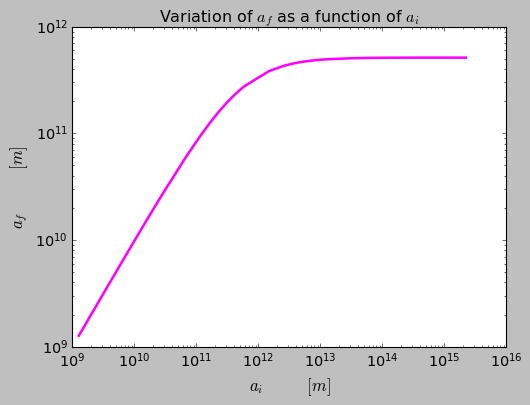

In [8]:
#Plot of a_f vs a_i for M_1PBH=10M☉ and M_2PBH=10M☉.


M_1PBH=10*M_solar      # in units of kg
M_2PBH=10*M_solar       # in units of kg



a_i_6_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_6_list[i] = a(λ_0)

    
a_f_6_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_6_list,s_dec_list)):
    a_f_6_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_6_list,a_f_6_list,'#FF00FF')
plt.xlabel("$a_{i}\hspace{3} [m]$",fontsize=15)
plt.ylabel("$a_{f}\hspace{3} [m]$",fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

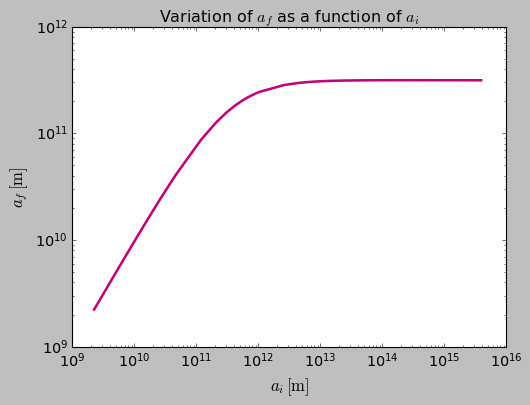

In [9]:
#Plot of a_f vs a_i for M_1PBH=10M☉ and M_2PBH=100M☉.

M_1PBH=10*M_solar        # in units of kg
M_2PBH=100*M_solar       # in units of kg



    
a_i_7_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_7_list[i] = a(λ_0)

    
a_f_7_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_7_list,s_dec_list)):
    a_f_7_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_7_list,a_f_7_list,'#C20078')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

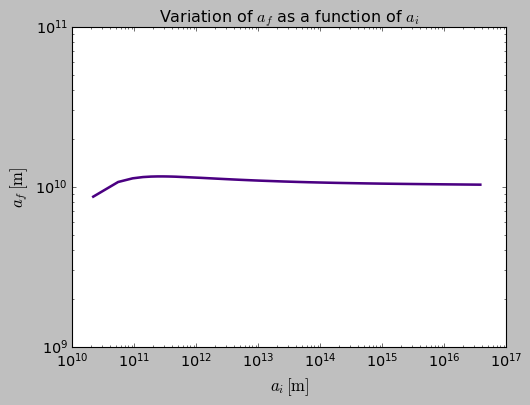

In [10]:
#Plot of a_f vs a_i for M_1PBH=10M☉ and M_2PBH=1e5M☉.

M_1PBH=10*M_solar        # in units of kg
M_2PBH=1e5*M_solar       # in units of kg


    
a_i_8_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_8_list[i] = a(λ_0)

    
a_f_8_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_8_list,s_dec_list)):
    a_f_8_list[i]=a_f(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_8_list,a_f_8_list,'#4B0082')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

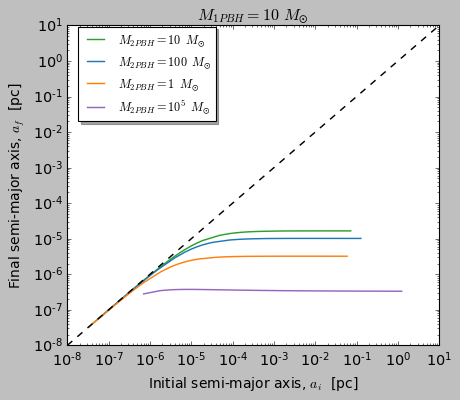

In [13]:
#Combined plot of a_f vs a_i for M_1PBH fixed and M_2PBH being varied.


#Combined plot of a_f vs a_i for M_1PBH=M_2PBH≡M_PBH.


pc=3.085e16   # in units of meter
C=1/pc

A=np.geomspace(1e-8,10,1000000)
A_i_list=A.tolist()

def A_f(A_i):
    return A_i

A_f_list=np.zeros(len(A_i_list))
for i, A_i  in enumerate (A_i_list):
    A_f_list[i]=A_f(A_i)
    


plt.figure(figsize=(6,5))
plt.rc('lines', linewidth=1.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.loglog(a_i_6_list*C,a_f_6_list*C,'tab:green')
plt.loglog(a_i_7_list*C,a_f_7_list*C,'tab:blue')
plt.loglog(a_i_5_list*C,a_f_5_list*C,'tab:orange')
plt.loglog(a_i_8_list*C,a_f_8_list*C,'tab:purple')
plt.loglog(A_i_list,A_f_list,'k--')
plt.xlim(1e-8,10)
plt.ylim(1e-8,10)

plt.xlabel('Initial semi-major axis, $a_{i}$  [pc]',fontsize=12.5)
plt.ylabel('Final semi-major axis, $a_{f}$  [pc]',fontsize=12.5)
plt.legend(["$M_{2PBH}=10\hspace{0.5} M_{☉}$","$M_{2PBH}=100\hspace{0.5} M_{☉}$","$M_{2PBH}=1\hspace{0.5} M_{☉}$",
            "$M_{2PBH}=10^{5}\hspace{0.5} M_{☉}$"], prop = {'size':11}, facecolor = 'white',loc=(0.03,0.7),shadow = True,fontsize=33)

plt.title('$M_{1PBH}=10$ $M_{☉}$')
plt.savefig('a_f vs a_i with diff.PBHs masses.pdf')
plt.show()

In [13]:
# Plot of final semi-major axis, a_f as a function of the initial semi-major axis, a_i of 
# the PBH-binary with dark matter halo's density profile of ρ(r)∝ r^{-3/2}. 
# The binary is having no halos in the final configuration and hence their final size if given
# by the Schwarzchild radii of the PBHs in the binary.

In [19]:
# Plotting of a_f vs a_i for the equal mass PBH binaries i.e. M_1PBH=M_2PBH≡M_PBH for
# dark matter halo's density profile of ρ(r)∝ r^{-3/2}.

# Plotting of a_f vs a_i for the equal mass PBH binaries i.e. M_1PBH=M_2PBH≡M_PBH for dark matter halo's density profile of ρ(r)∝ r^{-3/2}.

        
# Plotting of a_f vs a_i for the equal mass PBH binaries i.e. M_1PBH=M_2PBH≡M_PBH for dark matter halo's density profile of ρ(r)∝ r^{-3/2}.


def M_DM(M_PBH,s): # Initial mass of the dark halo of PBH  with mass M_PBH.                   
    return (M_PBH*(t(s)/t_eq))



def m(s): #Eq.(44) in "PBH-Binary" notes.
    return (1/(1+(math.sqrt(3/(8*π*G*ρ_eq*(t_eq**2)))*(((2/3)*(s-2)*math.sqrt(s+1))+(4/3)))))

                   
def λ_(s):
    return λ_0*m(s)
   

    
def s(λ_0):   # Function to calculate the scale-factor of the PBH binary decouple from Hubble flow.
    def f_(u,s,λ_0):
            return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ_(s)
                     *((u[0]**2+b**2)**(3/2))))]   
    separation0= [1e-12,1]
    b= (3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),100000) 
    us= odeint(f_,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        s=(As[i]*λ_0)             # As ss=s/λ_0.
        if Δ<0:
            break
        
    return s







def a_(λ_0):   #Function to calculate the initial semi-major axis of the PBH binary
    def f_(u,s,λ_0):
        return [u[1], -((s*g(s)+h(s))*((s*u[1]-u[0]))/(h(s)*s**2))-((u[0])/((((h(s)*s)**2))*λ_(s)
                     *((u[0]**2+b**2)**(3/2))))]    
    separation0= [1e-12,1]
    b=(3*λ_0)/100000
    ss= np.linspace(1e-12,((6*λ_0)/3),1000000) 
    us= odeint(f_,separation0,ss,args=( λ_0,))
    separations= us[:,0]
    As=ss/λ_0
    Bs=separations/λ_0
    Bs_list = Bs.tolist()
    As_list = As.tolist()
    for i in  range(1,len(Bs_list)):
        Δ=(Bs[i] - Bs[i-1])
        A=Bs[i]
        semi=(((A/2)*λ_0))                   #As Bs=separations/λ_0.
        if Δ<0:
            x=(((3*(M_1PBH+M_2PBH)*λ_0)/(8*π*ρ_eq))**(1/3))    # The initial comoving separation of the PBH binary in units of meter.
            a=(x*semi)
            break
        
    
    return a


def M(M_PBH,s):   #Mass of PBH + Initial mass of it's dark matter halo having size r=r_ta.
    return (M_PBH + M_DM(M_PBH,s))

def alpha(M_PBH):
    return ((3/(8*π))*M_PBH*((2*G*M_PBH*(t_eq**2))**(-1/2)))

def E_bg(M_PBH,λ_0,s): # The binding energy, E_b of the dark matter halos calculated within r_min/2 and r_ta.
    return -((8*π*G*alpha(M_PBH)*M_PBH*(((r_ta(M_PBH,s))**(1/2))-((r_s(M_PBH))**(1/2))))+((16/3)*G*(π**2)*(alpha(M_PBH)**2)*(((r_ta(M_PBH,s))**(2))-((r_s(M_PBH))**(2)))))


def a_fg(λ_0,a_i,s): #Final semi-major axis of the PBH binary.
    return ((G*M_1PBH*M_2PBH*a_i)/((G*M(M_1PBH,s)*M(M_2PBH,s))-(2*a_i*(E_bg(M_1PBH,λ_0,s)+E_bg(M_2PBH,λ_0,s)))))


s_dec_1_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate(λ_list):
    s_dec_1_list[i]= s(λ_0)      

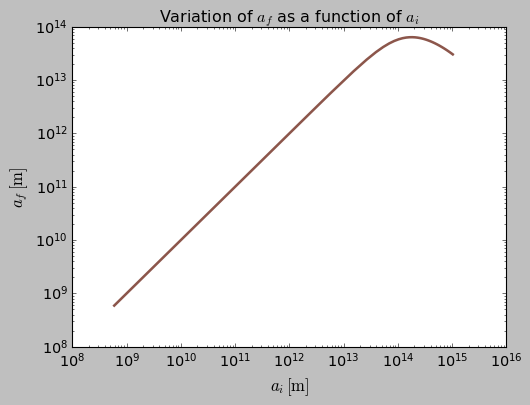

In [20]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=M_2PBH=1M☉. 

M_1PBH=1*M_solar      # in units of kg
M_2PBH=1*M_solar     # in units of kg 
    
a_i_9_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_9_list[i] = a_(λ_0)

    
a_f_9_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_9_list,s_dec_1_list)):
    a_f_9_list[i]=a_fg(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_9_list,a_f_9_list,'tab:brown')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

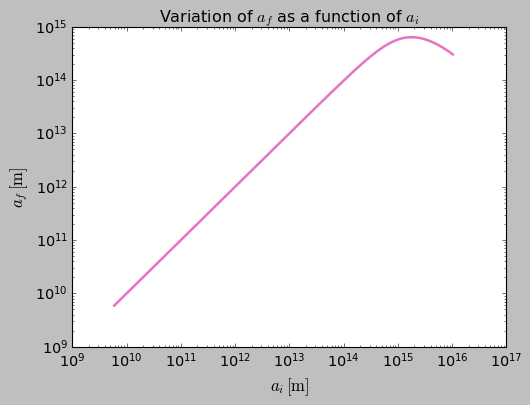

In [21]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=M_2PBH=1000M☉. 

M_1PBH=1000*M_solar      # in units of kg
M_2PBH=1000*M_solar     # in units of kg


a_i_10_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_10_list[i] = a_(λ_0)

    
a_f_10_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_10_list,s_dec_1_list)):
    a_f_10_list[i]=a_fg(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_10_list,a_f_10_list,'tab:pink')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

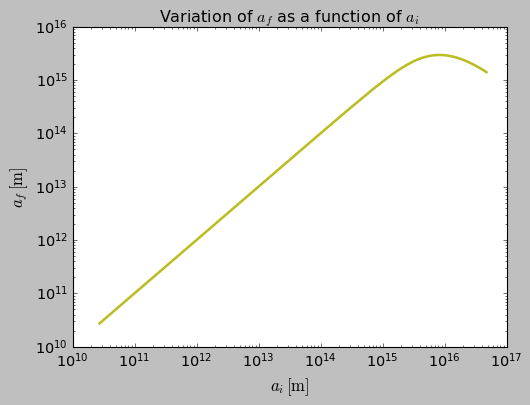

In [22]:
#Plot of a_f vs a_i for PBHs of masses M_1PBH=M_2PBH=1e5M☉. 

M_1PBH=1e5*M_solar      # in units of kg
M_2PBH=1e5*M_solar      # in units of kg

    
a_i_11_list=np.zeros(len(λ_list))
for i, λ_0 in enumerate (λ_list):
    a_i_11_list[i] = a_(λ_0)

    
a_f_11_list=np.zeros(len(λ_list))
for i, (λ_0,a_i,s) in enumerate (zip(λ_list,a_i_11_list,s_dec_1_list)):
    a_f_11_list[i]=a_fg(λ_0,a_i,s)
    

plt.figure(figsize=(7,5))
plt.rc('lines', linewidth=2.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.loglog(a_i_11_list,a_f_11_list,'tab:olive')
plt.xlabel('$a_{i} \, [\mathrm{m}]$',fontsize=15)
plt.ylabel('$a_{f} \, [\mathrm{m}]$',fontsize=15)
plt.title('Variation of $a_{f}$ as a function of $a_{i}$')
plt.show()

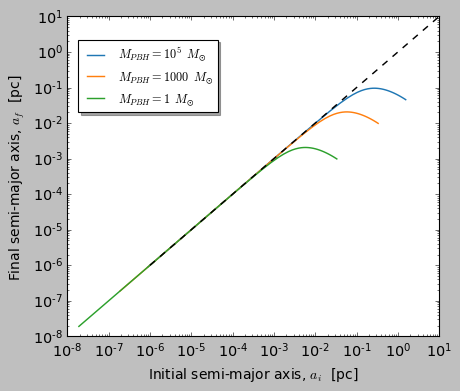

In [23]:
# Combined plot of a_f vs a_i for M_1PBH=M_2PBH≡M_PBH for for dark matter halo's density profile 
# of ρ(r)∝ r^{-3/2}.



pc=3.085e16   # in units of meter
C=1/pc



A=np.geomspace(1e-6,10,1000000)
A_i_list=A.tolist()

def A_f(A_i):
    return A_i

A_f_list=np.zeros(len(A_i_list))
for i, A_i  in enumerate (A_i_list):
    A_f_list[i]=A_f(A_i)
    

plt.style.use('classic')


plt.figure(figsize=(6,5))
plt.rc('lines', linewidth=1.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.loglog(a_i_11_list*C,a_f_11_list*C,'tab:blue')
plt.loglog(a_i_10_list*C,a_f_10_list*C,'tab:orange')
plt.loglog(a_i_9_list*C,a_f_9_list*C,'tab:green')
plt.loglog(A_i_list,A_f_list,'k--')



plt.xlabel('Initial semi-major axis, $a_{i}$  [pc]',fontsize=12.5)
plt.ylabel('Final semi-major axis, $a_{f}$  [pc]',fontsize=12.5)
plt.legend(["$M_{PBH}=10^{5}\hspace{0.5}M_{☉}$","$M_{PBH}=1000\hspace{0.5}M_{☉}$",
            "$M_{PBH}=1\hspace{0.5}M_{☉}$"], prop = {'size':11}, facecolor = 'white',loc=(0.03,0.7),shadow = True,fontsize=33)

plt.savefig('a_f vs a_i for older density profiles.pdf')
plt.show()

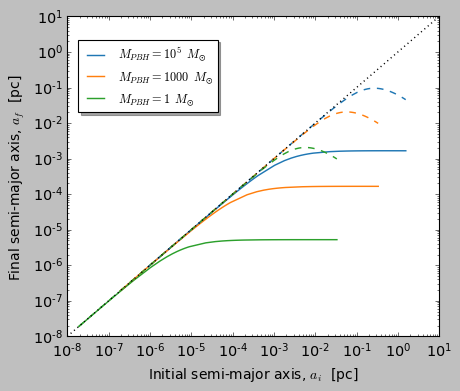

In [26]:
# Combined plot of a_f vs a_i for M_1PBH=M_2PBH≡M_PBH for for dark matter halo's density profile 
# of ρ(r)∝ r^{-3/2} and density profile of ρ(r)∝ r^{-9/4}. 



pc=3.085e16   # in units of meter
C=1/pc

A=np.geomspace(1e-8,10,1000000)
A_i_list=A.tolist()

def A_f(A_i):
    return A_i

A_f_list=np.zeros(len(A_i_list))
for i, A_i  in enumerate (A_i_list):
    A_f_list[i]=A_f(A_i)
    

plt.style.use('classic')

plt.figure(figsize=(6,5))
plt.rc('lines', linewidth=1.3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)






plt.loglog(a_i_4_list*C,a_f_4_list*C,'tab:blue')
plt.loglog(a_i_3_list*C,a_f_3_list*C,'tab:orange')
plt.loglog(a_i_1_list*C,a_f_1_list*C,'tab:green')

plt.loglog(a_i_11_list*C,a_f_11_list*C,'tab:blue',linestyle='dashed')
plt.loglog(a_i_10_list*C,a_f_10_list*C,'tab:orange',linestyle='dashed')
plt.loglog(a_i_9_list*C,a_f_9_list*C,'tab:green',linestyle='dashed')


plt.loglog(A_i_list,A_f_list,'k:')

plt.xlabel('Initial semi-major axis, $a_{i}$  [pc]',fontsize=12.5)
plt.ylabel('Final semi-major axis, $a_{f}$  [pc]',fontsize=12.5)
plt.legend(["$M_{PBH}=10^{5}\hspace{0.5}M_{☉}$","$M_{PBH}=1000\hspace{0.5}M_{☉}$",
            "$M_{PBH}=1\hspace{0.5}M_{☉}$"], prop = {'size':11}, facecolor = 'white',loc=(0.03,0.7),shadow = True,fontsize=33)

plt.savefig('a_f vs a_i combined density profiles.pdf')
plt.show()